In [1]:
from __future__ import division

import matplotlib.pyplot as plt
import nengo
from nengo import spa
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%matplotlib inline
%load_ext nengo.ipynb

<IPython.core.display.Javascript object>

In [3]:
from sparat.data_processing.generate_association_matrix import load_assoc_mat
from sparat.model.model import sanitize

#### Load association matrix

In [4]:
assoc_dir = '../data/associationmatrices/'

#assoc_faas, i2w_faas, w2i_faas = load_assoc_mat(assoc_dir, 'freeassoc_undir_symmetric')
#np.fill_diagonal(assoc_faas, 0.)

assoc_fang, i2w_fng, w2i_fng = load_assoc_mat(assoc_dir, 'freeassoc_google_symmetric')
np.fill_diagonal(assoc_fang, 0.)

#assert i2w_faas == i2w_fng
#assert w2i_faas == w2i_fng
i2w = i2w_fng
w2i = w2i_fng

#### Generate vocabulary

In [5]:
vocab = spa.Vocabulary(2048)
for w in i2w:
    vocab.parse(sanitize(w))

## Neural model

Let $c$ be the vector of the sum of the three cue vectors and $A$ the association matrix used in the filtering (`assoc_fang`). Furthermore, the vector for the current response to make a decision for (suppress or output) is $r$. All of these vectors (and association matrix) are assumed to be in the 5018d sparse word space (as opposed ot the semantic pointer space).

Analytically, we want to compute the dot product of $Ac$ and $r$ and use that as utility for outputting the word $r$. Written in matrix multiplication notation we can slightly transform this:

$$(Ac)^{\top}r = c^{\top}(A^{\top}r)$$

Thus, instead of determining the associations of $c$, we can determine the backwards associations of $r$ by using the transpose of $A$. *Note, that the $A$ here is symmetric and we can drop the transpose. Therefore, I did not pay attention to using the correct transpose in the code below and adjustments might be necessary for non-symmetric association matrices.*

Because we are operating in the sparse word space the vectors consist purely of 1s and 0s; also, the specific association matrix is binary. Thus, the dot product between $c$ and $A^{\top}r$ is essentially and element-wise and operation. Instead of using product networks, this can be better implemented using thresholding ensembles where we said the threshold so that an ensemble will only be active iff it is getting input because of $c$ and $A^{\top}r$.

Note that because we operate in the word space and treat each dimension independently we do not run into radius scaling issues. If we would operate in the semantic pointer space we would get a superposition of multiple vectors, but an unknown normlization factor because the number of associations for each word differs.

The only remaining question is: How do we get from the semantic pointer space into the word space? First of all, we already got $r$ in the word space as the output of the main models WTA before it gets projected back to the semantic pointer space. (In the model below we use an additional cleanup memory because we don't have access to the WTA from the main model.) On the connection from the WTA (respectively cleanup) to the thresholdinng ensembles we can apply $A^{\top}$ as a transformation. To get the cue vector into the word space we can use a cleanup memory. Actually, we can use the thresholding ensembles as this cleanup.

So overall the filtering would add one 5018d ensemble array of thresholding ensembles and and 1d ensemble for the result to the main model to do the filtering.

In [6]:
# three cues
cues = ['PIKE', 'COAT', 'SIGNAL']

# proposals is the list of words to filter
proposals = [
    'MONEY', 'CAR', 'SIREN', 'CUE', 'CLUE', 'BUSY', 'TURN', 'WEIRD', 'WARN', 'SIGN', 'WARNING',
    'RED', 'STOPLIGHT', 'BROWN', 'COLD', 'WOOL', 'JACKET', 'SUEDE', 'HEAVY', 'BUTTON', 'SLEEVE',
    'CLOTHES', 'SUIT', 'UNIFORM', 'PAINT', 'FURRY', 'ANIMAL', 'HOUSE', 'HORSE', 'HIGHWAY',
    'MOUNTAIN', 'TOP', 'PEAK', 'SPIKE', 'FISH', 'REEF', 'DRIVE', 'INTERSTATE', 'MUSEUM', 'DUE',
    'HOMEWORK', 'CHICKEN', 'LITTLE', 'DEPLETION', 'NUT', 'CHALK', 'KNOW', 'SPOON', 'UTENSIL',
    'FORK', 'SILVERWARE', 'HAT', 'PAINTER', 'BEAT', 'PRICKLY', 'PEAR', 'FRATERNITY', 'CLUB',
    'BELONG', 'LOVE', 'FORBIDDEN', 'ILLEGAL', 'WRONG', 'PERSON', 'SMART', 'INTELLIGENT', 'NAIVE',
    'ZENITH', 'WAFFLES', 'GREEN', 'LUXURY', 'BILL']

# Stimulus function
def propose(t):
    i = int(t // 0.4)
    if i < len(proposals):
        return proposals[i]
    else:
        return '0'

In [7]:
d = vocab.dimensions

with spa.SPA(vocabs=[vocab]) as model:
    with nengo.Config(spa.State) as cfg:
        cfg[spa.State].radius_method = nengo.utils.optimization.RadiusForUnitVector
        model.cues = spa.State(d)
        model.proposed = spa.State(d)
        
    # This will convert the SP for the response to its backwards associations in the word space.
    # Essentially, we do a cleanup with input_vectors=vocab.vectors, and use the vector of
    # backward associations for the output vectors (instead of projecting back to the SP space).
    # Note that output_vectors (input_vectors) is essentially just the transform to
    # apply to the output (input). When integrating this with the main model this associative
    # memory is not needed. It is possible to take the elem_output of the WTA and apply assoc_fang.T
    # as transform instead.
    model.am = nengo.networks.AssociativeMemory(vocab.vectors, assoc_fang.T)
    
    # We use the associative memory here as a convenient way to
    #   a) get an array of thresholding ensembles,
    #   b) do in input transformation for the cues to implement the cleanup required for these.
    # In the end we are only interested in how many ensembles are active. Thus, this AM does not
    # output actual vectors but just ones for each active ensemble that will get added up.
    # 
    # The threshold is set to 0.5 because each active input (from cues or response) will be scaled
    # to increase the value by ~0.3. Given a single input this is far below the threshold. Given
    # input from a cue and response association this adds up to ~0.6 and exceeds the threshold by
    # enough to get a response close to 1 (we're using step function like thresholding here)
    model.keep_response = nengo.networks.AssociativeMemory(
        vocab.vectors, np.ones((len(vocab.vectors), 1)), threshold=0.5)
    model.keep_response.add_threshold_to_outputs()
    
    # Each individual cue in the cue vector will have a scaling of 0.58 (see below), we need do
    # divide by 2 to get the scaling required by keep_response.
    nengo.Connection(model.cues.output, model.keep_response.input, transform=.5)
    
    # We scale the response vector in the same way as each individual cue
    nengo.Connection(model.proposed.output, model.am.input)
    nengo.Connection(model.am.output, model.keep_response.elem_input, transform=.5*.58)
    
    # The result, up to three ensembles can be active and output a one, so we need to increase the
    # radius of this ensemble.
    model.th = nengo.Ensemble(100, dimensions=1, radius=3)
    
    # Required transform is done by output_vectors of the associative memory keep_responses
    nengo.Connection(model.keep_response.output, model.th)
    
    model.stimulus = spa.Input()
    model.stimulus.cues = '0.58 * ({})'.format('+'.join(cues))
    model.stimulus.proposed = propose
    
    p = nengo.Probe(model.th, synapse=0.03)

In [8]:
import nengo_ocl
with nengo_ocl.Simulator(model) as sim:
    sim.run(0.4 * len(proposals))

No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:
No context argument was provided to nengo_ocl.Simulator
Calling pyopencl.create_some_context() for you now:


/home/jgosmann/.virtualenvs/bleeding-edge/lib/python2.7/site-packages/nengo_ocl-0.1.1.dev0-py2.7.egg/nengo_ocl/simulator.py:565: RuntimeWarning: Function 'parse_func' could not be converted to OCL due to AttributeError("'Call' object has no attribute 'value'",)
  % (fn_name, e.__class__.__name__, e.args), RuntimeWarning)


Here we plot the value of the thresholding ensemble `th`.

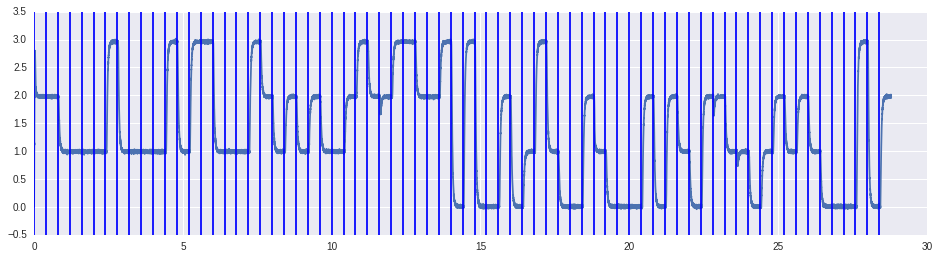

In [9]:
plt.figure(figsize=(16, 4))
plt.plot(sim.trange(), sim.data[p])
for i in range(len(proposals)):
    plt.axvline(x=0.4 * i)

Let us do the actual thresholding. Note that we don't cut off the responses after the solution word was found (as opposed to the analytical filtering).

In [10]:
utilities = np.max(sim.data[p].reshape((-1, 400))[:, 200:], axis=1)
threshold = 1.9
selected = [proposals[i] for i in np.where(utilities > threshold)[0]]

In [11]:
selected

['MONEY',
 'CAR',
 'TURN',
 'RED',
 'BROWN',
 'COLD',
 'HEAVY',
 'BUTTON',
 'CLOTHES',
 'UNIFORM',
 'ANIMAL',
 'HOUSE',
 'HORSE',
 'HIGHWAY',
 'MOUNTAIN',
 'TOP',
 'PEAK',
 'SPIKE',
 'FISH',
 'DRIVE',
 'DUE',
 'LITTLE',
 'KNOW',
 'HAT',
 'BEAT',
 'FRATERNITY',
 'CLUB',
 'WRONG',
 'SMART',
 'GREEN',
 'BILL']